In [1]:
import os
import cv2
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [2]:
from google.colab import drive
drive.mount('/content/My_Drive')

Mounted at /content/My_Drive


In [3]:
faces_path = '/content/My_Drive/My Drive/information_system_assignment_1/orl_dataset/'
nonfaces_path = '/content/My_Drive/My Drive/information_system_assignment_1/non_face/'

In [4]:
def save_data():
  DM_nonfaces = np.empty((0 , 10304))
  for img in os.listdir(nonfaces_path):
    non_face_img = cv2.imread(nonfaces_path + img , cv2.IMREAD_GRAYSCALE)
    resized = cv2.resize(non_face_img , (92 , 112))
    resized = resized.reshape(1 , 10304) 
    DM_nonfaces = np.append(DM_nonfaces , resized , axis=0)

  np.save('/content/My_Drive/My Drive/information_system_assignment_1/data_x_nonface' , DM_nonfaces)  

In [ ]:
save_data()

In [5]:
def set_data(no_nonface = 100):
  DM_faces = np.load('/content/My_Drive/My Drive/information_system_assignment_1/data_x.npy')
  Y_labels_faces = np.ones((400 , 1))


  DM_nonfaces = np.load('/content/My_Drive/My Drive/information_system_assignment_1/data_x_nonface.npy')
  Y_labels_nonfaces = np.zeros((300 , 1))

  np.random.seed(0)
  DM_nonfaces , Y_labels_nonfaces = sklearn.utils.shuffle(DM_nonfaces , Y_labels_nonfaces)
  DM_nonfaces = DM_nonfaces[:no_nonface , :]
  Y_labels_nonfaces = Y_labels_nonfaces[:no_nonface , :]

  DM = np.append(DM_faces , DM_nonfaces , axis=0)
  Y_labels = np.append(Y_labels_faces , Y_labels_nonfaces , axis=0)

  np.random.seed(0)
  DM , Y_labels = sklearn.utils.shuffle(DM , Y_labels)


  return DM , Y_labels

In [6]:
def split_data(no_nonface = 100):  
  DM , Y_labels = set_data(no_nonface)
  DM_train, DM_test, y_train, y_test = train_test_split(DM , Y_labels , train_size = 0.7)
  return DM_train , y_train , DM_test , y_test

In [7]:
# centrig data
def center_data(data):
  Mean = (1/data.shape[0]) * (np.sum(data , axis=0 , keepdims=True))
  Z = data - Mean
  return Z

In [8]:
# DM of shape (no of samples , dimensions)
def PCA(DM , alpha):
  # shape = (no of examples , 10304)
  Z = center_data(DM)
  # shape = (10304 , 10304)
  cov = (1/DM.shape[0]) * (np.dot(np.transpose(Z) , Z))
  eigvals , eigvecs = np.linalg.eigh(cov)
  eigvals = np.flip(eigvals.reshape(eigvals.shape[0],1) , axis=0)
  eigvecs = np.flip(eigvecs , axis=1)
  
  f_r = 0
  new_dim = 0
  total_variance = np.sum(eigvals)
  for eigval in eigvals:
    f_r += eigval
    new_dim = new_dim + 1
    if f_r / total_variance >= alpha:
      break

  U_r = eigvecs[:, :new_dim].reshape(eigvecs.shape[0] , new_dim)
  print('proj_mat shape : ')
  print(U_r.shape)
  return U_r

In [12]:
def nearest_neighbors(DM_train , DM_test , Y_labels_train , Y_labels_test , n_neighbors = 1):
  knn = KNeighborsClassifier(n_neighbors = n_neighbors , weights='distance')
  knn.fit(DM_train, Y_labels_train) 
  # Calculate the accuracy of the model 
  accuracy = knn.score(DM_test, Y_labels_test) 
  return  str(accuracy * 100) + ' %' 

In [ ]:
def nearest_neighbors(DM_train , DM_test , Y_labels_train , Y_labels_test , n_neighbors = 1,no_nonface = 100):
  all_min_idx = np.empty((0))
  DM_train1 , Y_labels_train1 , DM_test1 , Y_labels_test1 = split_data(no_nonface)
  for i in range(DM_test.shape[0]):
    all_norms = np.linalg.norm(DM_train - DM_test[i].reshape(1 , DM_test.shape[1]) , axis=1 , keepdims=True)
    idx_arr = np.argmin(all_norms , axis=0)
    all_min_idx = np.append(all_min_idx , idx_arr , axis=0)
    

    if i==0 or i==5:
      show_test = DM_test1[i].reshape(112 , 92)
      print('test : ')
      print(Y_labels_test[i])
      cv2_imshow(show_test)
      show_train = DM_train1[idx_arr[0]].reshape(112 , 92)
      print('train : ')
      print(Y_labels_train[idx_arr[0]]) 
      cv2_imshow(show_train)
    
  all_min_idx = all_min_idx.reshape(all_min_idx.shape[0] , 1)
  print(all_min_idx)
  print(all_min_idx.shape)


  accuracy = 0
  for j in range(all_min_idx.shape[0]):

    if Y_labels_test[j] == Y_labels_train[int(all_min_idx[j])]:
      accuracy = accuracy + 1

  accuracy_percent =  str((accuracy / Y_labels_test.shape[0]) * 100) + ' %'
  return accuracy_percent

In [13]:
def get_proj (alpha , no_nonface = 100):
  DM_train , Y_labels_train , DM_test , Y_labels_test = split_data(no_nonface)
  projection_matrix = PCA(DM_train , alpha)
  return projection_matrix

In [15]:
def classify(projection_matrix , n_neighbors = 1  , no_nonface = 100):
  DM_train , Y_labels_train , DM_test , Y_labels_test = split_data(no_nonface)
  #projection_matrix = PCA(DM_train , alpha)

  # project train and test data
  DM_train_center = center_data(DM_train)
  DM_train_proj = np.dot(DM_train_center , projection_matrix)
  DM_test_center = center_data(DM_test)
  DM_test_proj = np.dot(DM_test_center , projection_matrix)


  accuracy = nearest_neighbors(DM_train_proj , DM_test_proj , Y_labels_train , Y_labels_test , n_neighbors)
  print(accuracy)
  return accuracy

proj_mat shape : 
(10304, 43)
88.0 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


proj_mat shape : 
(10304, 51)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


96.66666666666667 %
proj_mat shape : 
(10304, 54)
90.99526066350711 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


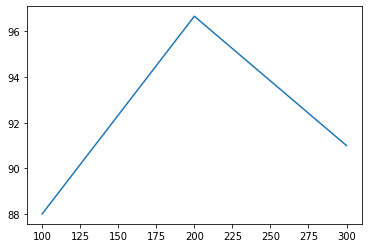

In [ ]:
nonface_size = [100 , 200 , 300]

accs = []
for i in range(3):
  projection_matrix = get_proj (0.8 , no_nonface = nonface_size[i])
  accs.append(float(classify(projection_matrix , no_nonface = nonface_size[i])[:-1]))

plt.plot(nonface_size , accs)
plt.show()

proj_mat shape : 
(10304, 54)
test : 
[0.]


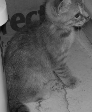

train : 
[0.]


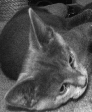

test : 
[0.]


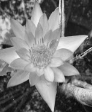

train : 
[1.]


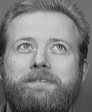

[[378.]
 [242.]
 [458.]
 [272.]
 [ 84.]
 [346.]
 [480.]
 [ 45.]
 [ 31.]
 [114.]
 [248.]
 [340.]
 [372.]
 [ 11.]
 [293.]
 [130.]
 [146.]
 [145.]
 [ 65.]
 [399.]
 [279.]
 [217.]
 [272.]
 [ 39.]
 [464.]
 [357.]
 [ 70.]
 [ 37.]
 [353.]
 [ 31.]
 [286.]
 [ 94.]
 [342.]
 [ 34.]
 [181.]
 [ 11.]
 [ 81.]
 [276.]
 [235.]
 [  8.]
 [366.]
 [ 69.]
 [450.]
 [292.]
 [290.]
 [ 39.]
 [455.]
 [413.]
 [211.]
 [222.]
 [360.]
 [ 35.]
 [ 51.]
 [ 61.]
 [116.]
 [454.]
 [206.]
 [ 69.]
 [317.]
 [113.]
 [195.]
 [236.]
 [190.]
 [ 99.]
 [ 40.]
 [236.]
 [236.]
 [428.]
 [112.]
 [ 25.]
 [487.]
 [424.]
 [121.]
 [475.]
 [382.]
 [173.]
 [192.]
 [412.]
 [ 46.]
 [217.]
 [ 73.]
 [381.]
 [456.]
 [  3.]
 [116.]
 [445.]
 [344.]
 [109.]
 [227.]
 [311.]
 [ 64.]
 [ 85.]
 [ 14.]
 [181.]
 [374.]
 [ 14.]
 [273.]
 [231.]
 [178.]
 [328.]
 [482.]
 [316.]
 [357.]
 [ 39.]
 [453.]
 [ 36.]
 [109.]
 [393.]
 [309.]
 [124.]
 [149.]
 [372.]
 [158.]
 [235.]
 [202.]
 [441.]
 [325.]
 [242.]
 [429.]
 [454.]
 [ 39.]
 [372.]
 [359.]
 [ 80.]
 [ 79.]


'88.62559241706161 %'

In [ ]:
classify(get_proj(0.8) , no_nonface=300)

proj_mat shape : 
(10304, 51)
93.8388625592417 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


91.4691943127962 %
86.7298578199052 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


85.30805687203792 %


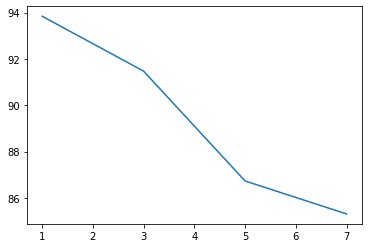

proj_mat shape : 
(10304, 83)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


94.3127962085308 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


86.25592417061611 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


88.62559241706161 %
80.09478672985783 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


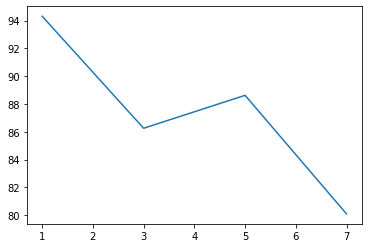

proj_mat shape : 
(10304, 121)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


89.57345971563981 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


87.67772511848341 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


85.78199052132702 %
82.46445497630332 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


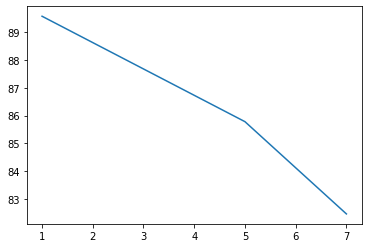

proj_mat shape : 
(10304, 210)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


87.67772511848341 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


85.30805687203792 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


86.25592417061611 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


79.62085308056872 %


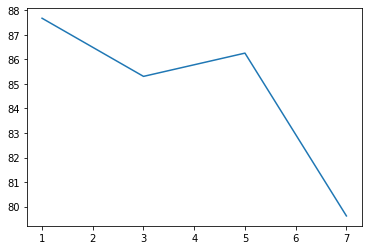

In [ ]:
Ks = [1,3,5,7]
alphas = [0.8 , 0.85 , 0.9 , 0.95]
for alpha in alphas:
  projection_matrix = get_proj (alpha)
  accs = []
  for i in range(4):
    accs.append(float(classify(projection_matrix , Ks[i])[:-1]))

  plt.plot(Ks , accs)
  plt.show()